In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from PIL import Image
import os
import cv2
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

In [2]:
print(os.listdir('/kaggle/input'))

['datathon-ai-qualification-round']


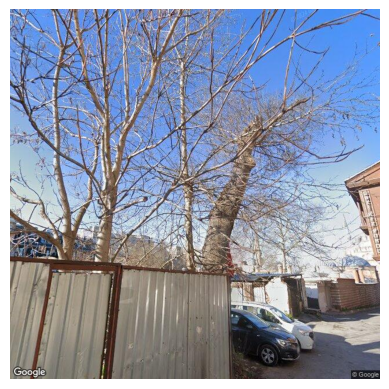

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/kaggle/input/datathon-ai-qualification-round/train/train/image_10000.jpg')

# Display the image inline
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()


In [4]:
class TurkishCitiesDataset(Dataset):
    def __init__(self, data, image_dir, transform=None):
        """
        Custom Dataset for Turkish Cities Street View Images
        
        Args:
            data (pd.DataFrame): DataFrame with image information
            image_dir (string): Directory with all the images
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.data_frame = data
        self.image_dir = image_dir
        self.transform = transform
        
        # Map city names to numeric labels
        self.label_map = {
            'Istanbul': 0,
            'Izmir': 1,
            'Ankara': 2
        }
        
        # Convert city names to numeric labels
        self.data_frame['label'] = self.data_frame['city'].map(self.label_map)
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Use the filename column directly
        img_name = os.path.join(self.image_dir, self.data_frame.iloc[idx]['filename'])
        
        # Ensure image exists
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image not found: {img_name}")
        
        # Read image using cv2 instead of PIL for Albumentations
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        label = self.data_frame.iloc[idx]['label']
        
        if self.transform:
            # Apply Albumentations transforms
            transformed = self.transform(image=image)
            image = transformed['image']
        
        return image, label

In [5]:
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10, patience=5):
    """
    Training function with F1 score tracking, learning rate scheduler, and early stopping
    
    Args:
        model (nn.Module): Neural network model
        dataloaders (dict): Dictionary of train and validation dataloaders
        criterion (nn.Module): Loss function
        optimizer (torch.optim): Optimizer
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler
        num_epochs (int): Number of training epochs
        patience (int): Number of epochs to wait for improvement before stopping early
    
    Returns:
        model: Trained model
    """
    best_f1 = 0.0
    best_model = None
    best_epoch = 0
    epochs_without_improvement = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            with torch.set_grad_enabled(phase == 'train'):
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # Compute predictions
                    _, preds = torch.max(outputs, 1)
                    
                    # Accumulate predictions and labels
                    running_loss += loss.item() * inputs.size(0)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            # Calculate epoch loss and F1 score
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            f1 = f1_score(all_labels, all_preds, average='weighted')
            
            print(f'{phase} Loss: {epoch_loss:.4f} F1 Score: {f1:.4f}')
            
            # Step the scheduler at the end of the training phase
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            # Deep copy the model if it's the best F1 score in validation
            if phase == 'val':
                if f1 > best_f1:
                    best_f1 = f1
                    best_model = model.state_dict().copy()
                    best_epoch = epoch
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
        
        # Early stopping check
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best model saved from epoch {best_epoch+1}.")
            break

    # Load best model weights
    if best_model:
        model.load_state_dict(best_model)
    return model


In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

# Augmentations for City Classification
data_transforms = {
    'train': A.Compose([
        # Resize images to 224x224
        A.Resize(height=224, width=224, always_apply=True),
        
        # Geometric Transformations
        A.OneOf([
            A.HorizontalFlip(p=0.5),        # Flip horizontally
            A.RandomRotate90(p=0.5),        # Rotate 90 degrees randomly
            A.Transpose(p=0.5),             # Transpose rows and columns
        ], p=0.5),
        
        # Color and Contrast Adjustments
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=15, p=0.5),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),  # Contrast Limited Adaptive Histogram Equalization
        ], p=0.5),
        
        # Quality Transformations
        A.OneOf([
            A.ImageCompression(quality_lower=85, quality_upper=95, p=0.5),  # Simulate image compression
            A.MotionBlur(blur_limit=3, p=0.5),                             # Add motion blur
        ], p=0.3),
        
        # Lighting Adjustments
        A.RandomShadow(num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, p=0.3),  # Changed from 0.3 to 5
        
        # Normalize to pre-trained model standards and convert to tensor
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    
    'val': A.Compose([
        # Simple resizing and normalization for validation set
        A.Resize(height=224, width=224, always_apply=True),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
}
# Read train dataset
# Create a list of all image files in the train directory
train_dir = '/kaggle/input/datathon-ai-qualification-round/train/train'
train_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]

# Create DataFrame with filenames
train_df = pd.DataFrame({'filename': train_images})

# Read the labels CSV to map filenames to cities
labels_df = pd.read_csv('/kaggle/input/datathon-ai-qualification-round/train_data.csv')

# Merge the dataframes to get city labels
train_df = train_df.merge(labels_df[['filename', 'city']], on='filename', how='left')

# Check for any unmatched files
if train_df['city'].isnull().any():
    print("Warning: Some files could not be matched with labels!")
    # Optional: drop unmatched files
    train_df = train_df.dropna(subset=['city'])

# Split train data into train and validation sets (80-20 split)
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['city'])

# Create datasets
train_dataset = TurkishCitiesDataset(
    data=train_data, 
    image_dir='/kaggle/input/datathon-ai-qualification-round/train/train', 
    transform=data_transforms['train']
)

val_dataset = TurkishCitiesDataset(
    data=val_data, 
    image_dir='/kaggle/input/datathon-ai-qualification-round/train/train', 
    transform=data_transforms['val']
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Prepare dataloaders dict
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
next(iter(val_loader))[1]

tensor([0, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 2, 0, 0, 0, 1, 0, 2])

In [9]:
import timm

# Load pre-trained model
model = timm.create_model(
    'swin_large_patch4_window7_224', 
    pretrained=True, 
    num_classes=3  # Your number of city classes
)


model.safetensors:   0%|          | 0.00/788M [00:00<?, ?B/s]

In [10]:
from torch.optim.lr_scheduler import StepLR

# Define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [11]:
# Train the model
model = train_model(
    model=model,
    dataloaders={'train': train_loader, 'val': val_loader},
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,  # Pass the scheduler
    num_epochs=5,
    patience=3
)

# Save the trained model
torch.save(model.state_dict(), 'turkish_cities_best_classification_model.pth')

Epoch 1/5


100%|██████████| 175/175 [03:39<00:00,  1.25s/it]


train Loss: 0.4917 F1 Score: 0.8023


100%|██████████| 44/44 [00:19<00:00,  2.27it/s]


val Loss: 0.2705 F1 Score: 0.9047
Epoch 2/5


100%|██████████| 175/175 [03:38<00:00,  1.25s/it]


train Loss: 0.2280 F1 Score: 0.9129


100%|██████████| 44/44 [00:19<00:00,  2.26it/s]


val Loss: 0.2417 F1 Score: 0.9127
Epoch 3/5


100%|██████████| 175/175 [03:38<00:00,  1.25s/it]


train Loss: 0.1554 F1 Score: 0.9454


100%|██████████| 44/44 [00:19<00:00,  2.26it/s]


val Loss: 0.2185 F1 Score: 0.9245
Epoch 4/5


100%|██████████| 175/175 [03:38<00:00,  1.25s/it]


train Loss: 0.0983 F1 Score: 0.9655


100%|██████████| 44/44 [00:19<00:00,  2.26it/s]


val Loss: 0.2921 F1 Score: 0.9148
Epoch 5/5


100%|██████████| 175/175 [03:38<00:00,  1.25s/it]


train Loss: 0.0812 F1 Score: 0.9707


100%|██████████| 44/44 [00:19<00:00,  2.26it/s]


val Loss: 0.2718 F1 Score: 0.9221


In [ ]:
import os
import pandas as pd
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare for prediction on test set
test_dir = '/kaggle/input/turkey-prominent-cities/test'
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
test_df = pd.read_csv('/kaggle/input/turkey-prominent-cities/test.csv')  # Load the existing test.csv

# Create test dataset and loader
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Prediction function
def predict_test_set(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    predictions = []
    
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    # Map predictions back to city names
    reverse_label_map = {
        '0' : 'Istanbul',
        '1' : 'Izmir',
        '2' : 'Ankara'
    }
    city_predictions = [reverse_label_map[f"{pred}"] for pred in predictions]
    
    return city_predictions

# Run predictions
test_predictions = predict_test_set(model, test_loader)

# Add predictions to the test_df (make sure that the test images and predictions match)
test_df['city'] = test_predictions

# Save the updated DataFrame with predictions to the same CSV file
test_df.to_csv('/kaggle/working/test_predictions.csv', index=False)

print("Predictions completed. Check 'test_predictions.csv'.")
